<a href="https://colab.research.google.com/github/mohammadbadi/CrimeAnalytics_Clustering/blob/main/Code%20Sections/5.5%20KMeans%20Feature%20Importance%20%26%205.6%20K-Elbow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **5.5 KMeans Feature Importance & 5.6 K-Elbow**

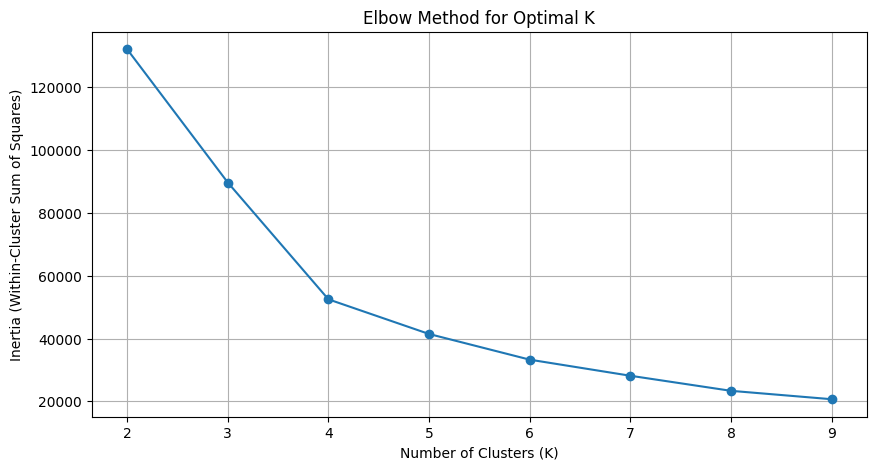

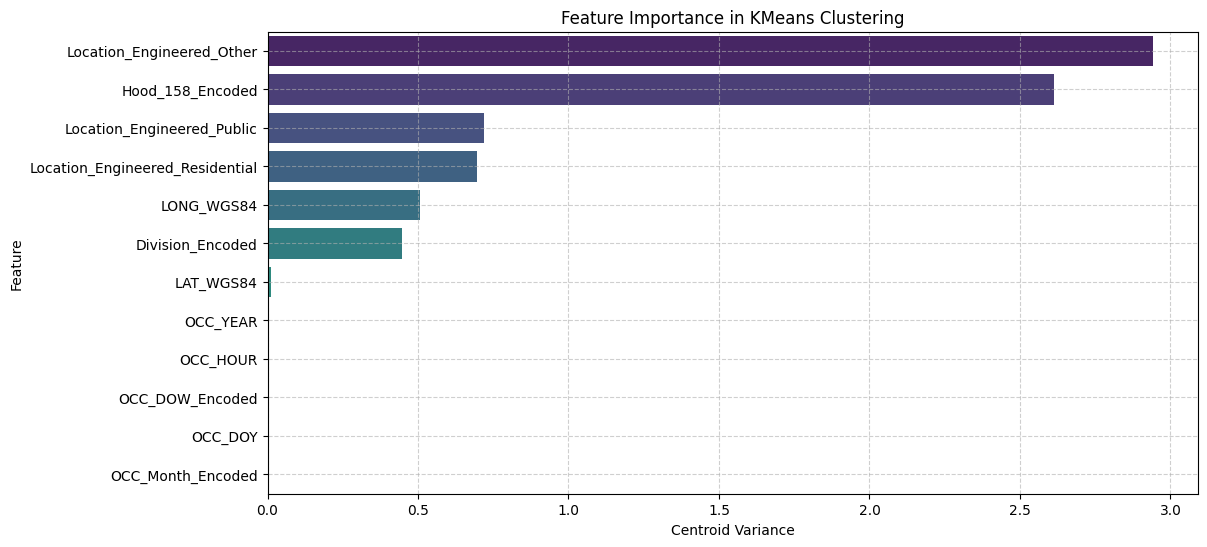

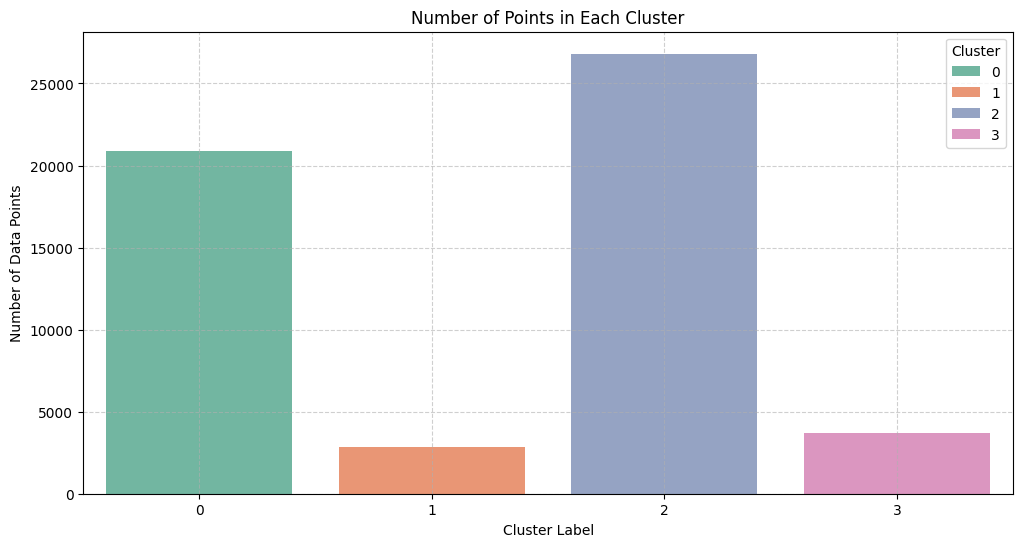

In [4]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from IPython.display import display, HTML

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load Data
url = "https://raw.githubusercontent.com/mohammadbadi/CrimeAnalytics_Clustering/refs/heads/main/Output_CSV/FE_Encoded.csv"
df = pd.read_csv(url)

# Define Features
continuous_features = ['OCC_YEAR', 'OCC_DOY', 'OCC_HOUR', 'LONG_WGS84', 'LAT_WGS84']
encoded_features = ['OCC_Month_Encoded', 'OCC_DOW_Encoded', 'Hood_158_Encoded', 'Division_Encoded',
                    'Location_Engineered_Other', 'Location_Engineered_Public', 'Location_Engineered_Residential']
features = continuous_features + encoded_features

# Standardization
scaler = StandardScaler()
preprocessor = ColumnTransformer([('num', scaler, features)])

# KMeans Clustering Pipeline (n_clusters=4 based on K-Elbow)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('kmeans', KMeans(n_clusters=4, random_state=42, n_init=10))
])

# Fit Pipeline
pipeline.fit(df)

# Transform Data
df_processed = pipeline.transform(df)

# Extract KMeans Model and assign cluster labels
kmeans = pipeline.named_steps['kmeans']
df['Cluster'] = kmeans.labels_

# Calculate Feature "Centroid Variance" (Variance of Centroid Values)
centroids = kmeans.cluster_centers_
centroid_variance = np.var(centroids, axis=0)
importance_df = pd.DataFrame({'Feature': features, 'Centroid Variance': centroid_variance})\
                  .sort_values(by='Centroid Variance', ascending=False)

# Calculate Clustering Metrics
sil_score = silhouette_score(df_processed, kmeans.labels_)
db_index = davies_bouldin_score(df_processed, kmeans.labels_)
ch_index = calinski_harabasz_score(df_processed, kmeans.labels_)
inertia_value = kmeans.inertia_

# Plot: Elbow Method Plot (Check Optimal K)
inertia_values = []
K_range = range(2, 10)
for k in K_range:
    kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_test.fit(df_processed)
    inertia_values.append(kmeans_test.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(K_range, inertia_values, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal K")
plt.grid(True)
plt.show()
display(HTML("<br><br>"))  # Two line breaks

# Plot: Feature Importance Bar Chart
plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df, x='Centroid Variance', y='Feature', palette='viridis')
plt.xlabel("Centroid Variance")
plt.ylabel("Feature")
plt.title("Feature Importance in KMeans Clustering")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
display(HTML("<br><br>"))  # Two line breaks

# Plot: Cluster Distribution Visualization
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Cluster', hue='Cluster', palette="Set2", dodge=False)
plt.title("Number of Points in Each Cluster")
plt.xlabel("Cluster Label")
plt.ylabel("Number of Data Points")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
display(HTML("<br><br>"))  # Two line breaks

# --- Build HTML table for KMeans Clustering Analysis ---
html_table = f"""
<table style='border-collapse: collapse; font-size: 18px; width: 100%; max-width: 900px; table-layout: fixed;'>
    <thead>
        <tr style='background-color: #2f4f4f; color: white;'>
            <th colspan="3" style="text-align: center; font-size: 24px; padding: 8px;">
                KMEANS Clustering Analysis
            </th>
        </tr>
        <tr>
            <td colspan="3" style="border: 1px solid #dddddd; padding: 8px; text-align: center; white-space: normal; word-wrap: break-word;">
                Based on the Optimal K value from the K-Elbow method, KMeans was performed with 4 clusters (n=4), which produced the following clustering statistics:
                <strong>Silhouette Score:</strong> {sil_score:.2f},
                <strong>Davies-Bouldin Index:</strong> {db_index:.2f},
                <strong>Calinski-Harabasz Index:</strong> {ch_index:.2f}, and
                <strong>Inertia:</strong> {inertia_value:.2f}.
                Centroid Variance represents the variance of the cluster centroids for each feature, reflecting its contribution to the clustering structure.
            </td>
        </tr>
        <tr style='background-color: #4CAF50; color: white;'>
            <th style='border: 1px solid #dddddd; padding: 8px;'>S/N</th>
            <th style='border: 1px solid #dddddd; padding: 8px;'>Feature</th>
            <th style='border: 1px solid #dddddd; padding: 8px;'>Centroid Variance</th>
        </tr>
    </thead>
    <tbody>
"""

# Add rows for each feature's centroid variance
for idx, row in enumerate(importance_df.itertuples(), start=1):
    feature_val = row.Feature
    variance_val = f"{row[2]:.4f}"  # row[2] is the 'Centroid Variance'
    html_table += f"""
        <tr style='border: 1px solid #dddddd;'>
            <td style='border: 1px solid #dddddd; padding: 8px; text-align: center;'>{idx}</td>
            <td style='border: 1px solid #dddddd; padding: 8px;'>{feature_val}</td>
            <td style='border: 1px solid #dddddd; padding: 8px; text-align: right;'>{variance_val}</td>
        </tr>
    """
html_table += """
    </tbody>
</table>
"""

# Display the HTML formatted table
display(HTML(html_table))
display(HTML("<br><br>"))  # Two line breaks

# Save updated dataset with Cluster Labels
df.to_csv("FE_Encoded_with_Clusters.csv", index=False)
display(HTML("""
    <p style="color: darkblue; font-size: 18px; font-weight: bold;">
         Updated dataset with cluster labels saved as <span style="color: green;">FE_Encoded_with_Clusters.csv</span>.
    </p>
"""))
